<a href="https://colab.research.google.com/github/UttaraKet1607/Malarial-Cell-Image-Segmentation/blob/main/Anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Resources
1. https://github.com/bnsreenu/python_for_microscopists/blob/master/260_image_anomaly_detection_using_autoencoders/260_image_anomaly_detection_using_autoencoders.py
2. https://www.youtube.com/watch?v=q_tpFGHiRgg
3. https://github.com/mayur7garg/MalariaCellImageClassification 

### Implementation

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download iarunava/cell-images-for-detecting-malaria
! unzip cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
  inflating: cell_im

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

In [4]:
import os
os.mkdir('/content/cell_images/Train_Uninfected')

In [5]:
import shutil

# absolute path
src_path = "/content/cell_images/Uninfected"
dst_path = "/content/cell_images/Train_Uninfected"
shutil.move(src_path, dst_path)

'/content/cell_images/Train_Uninfected/Uninfected'

In [6]:
os.mkdir('/content/cell_images/Test_Parasitized')

In [7]:
# absolute path
src_path = "/content/cell_images/Parasitized"
dst_path = "/content/cell_images/Test_Parasitized"
shutil.move(src_path, dst_path)

'/content/cell_images/Test_Parasitized/Parasitized'

In [10]:
#Size of our input images
Size = 128

#Define generators for training, validation and also anomaly data.

batch_size = 64
datagen_train = ImageDataGenerator(rescale=1./255, validation_split=0.3)
datagen = ImageDataGenerator(rescale=1./255)
train_dir = '/content/cell_images/Train_Uninfected'
test_dir = '/content/cell_images/Test_Parasitized'

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(Size, Size),
    batch_size=batch_size,
    class_mode='input',
    subset='training',
    seed=42)

validation_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(Size, Size),
    batch_size=batch_size,
    class_mode='input',
    subset='validation',
    seed=42)

anomaly_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(Size, Size),
    batch_size=batch_size,
    class_mode='input',
    seed=42)

Found 9646 images belonging to 1 classes.
Found 4133 images belonging to 1 classes.
Found 13779 images belonging to 1 classes.


In [11]:
#Define the autoencoder
tf.random.set_seed(42)

#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(Size, Size, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

In [13]:
#Fit the model. 
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=75 // batch_size,
        shuffle = True)

Epoch 1/100
7/7 [==============================] - 14s 258ms/step - loss: 0.0889 - mse: 0.0889 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 2/100
7/7 [==============================] - 2s 219ms/step - loss: 0.0603 - mse: 0.0603 - val_loss: 0.0407 - val_mse: 0.0407
Epoch 3/100
7/7 [==============================] - 2s 209ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 4/100
7/7 [==============================] - 2s 210ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 5/100
7/7 [==============================] - 2s 209ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0172 - val_mse: 0.0172
Epoch 6/100
7/7 [==============================] - 2s 209ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 7/100
7/7 [==============================] - 2s 209ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 8/100
7/7 [==============================] - 2s 208ms/step - loss: 0.0121 - 

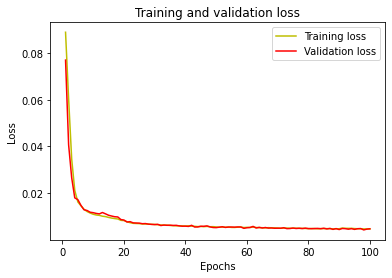

In [14]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])  #Predict on the first batch of images

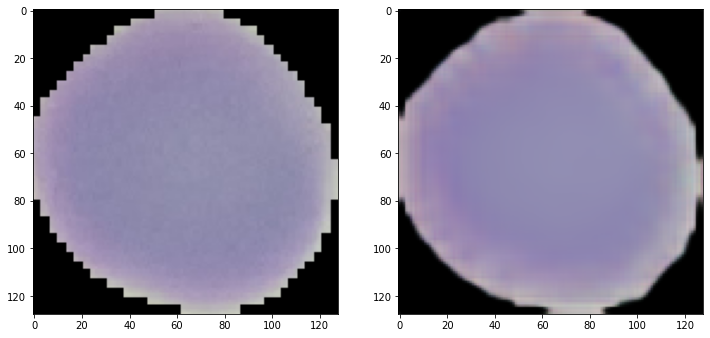

In [16]:
#View few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

In [17]:
#Let us examine the reconstruction error between our validation data (good/normal images)
# and the anomaly images
validation_error = model.evaluate_generator(validation_generator)
anomaly_error = model.evaluate_generator(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


Recon. error for the validation (normal) data is:  [0.004632150754332542, 0.004632150754332542]
Recon. error for the anomaly data is:  [0.005239945370703936, 0.005239945370703936]


In [18]:
#Let us extract (or build) the encoder network, with trained weights.
#Calculate KDE using compressed output
tf.random.set_seed(42)

encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(Size, Size, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)      

In [19]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict_generator(train_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


In [20]:
# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

In [21]:
#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

In [22]:
#Calculate density and reconstruction error to find their means values for
#good and anomaly images. 
#We use these mean and sigma to set thresholds. 
def calc_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error

In [25]:
#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
#For this let us generate a batch of images for each. 
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

uninfected_values = calc_density_and_recon_error(train_batch)

1/1 [==============================] - 0s 24ms/step - loss: 0.0066 - mse: 0.0066


In [26]:
anomaly_values = calc_density_and_recon_error(anomaly_batch)

1/1 [==============================] - 0s 23ms/step - loss: 0.0070 - mse: 0.0070


In [35]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    density_threshold = 2500 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.006 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")

In [36]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob('/content/cell_images/Test_Parasitized/Parasitized/*')
uninfected_file_paths = glob.glob('/content/cell_images/Train_Uninfected/Uninfected/*')

1/1 [==============================] - 0s 49ms/step - loss: 0.0058 - mse: 0.0058
The image is NOT an anomaly


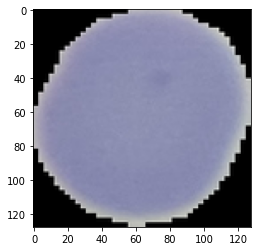

In [37]:
#Good/normal image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(uninfected_file_paths[num])

1/1 [==============================] - 0s 26ms/step - loss: 0.0075 - mse: 0.0075
The image is an anomaly


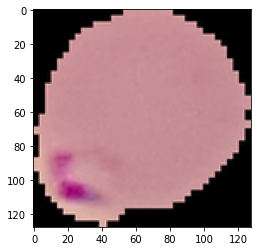

In [38]:
#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])